In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv
import random

import numpy as np

import requests
import json
import getpass

# from utils.prepS2 import *
# from utils.utils import reproject_wkt_4326_3460


# Landsat Query & Order

## Prep AoI Vectors and Ancillary datasets
- single or directory of shapefiles (anything readable by gpd)
- global sentinel-2 tile shapefile
- global landsat tile shapefile
- world borders shapefile (from TM_WORLD_BORDERS)

In [17]:
# Load all aois
# aois_dir = "../DY/"
# aois = [gpd.read_file(x) for x in glob.glob(aois_dir + '*.geojson')] # load aois
# aois = gpd.GeoDataFrame(pd.concat(aois)) # spatial join aois
aois = gpd.read_file('../DY/DY_AoI.geojson')

In [18]:
# Load landsat & sentinel-2 world tiles
# world_s2_granules = gpd.read_file('../Ancillary_Datasets/sentinel2_tiles_world/sentinel2_tiles_world.shp')
world_ls_granules = gpd.read_file('../Ancillary_Datasets/WRS2_descending.shp') # https://www.usgs.gov/land-resources/nli/landsat/landsat-shapefiles-and-kml-files


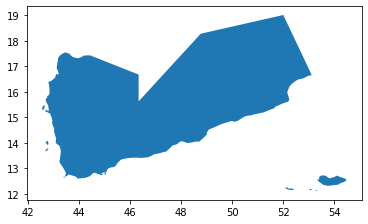

In [19]:
world_borders = gpd.read_file('../Ancillary_Datasets/TM_WORLD_BORDERS-0.2/TM_WORLD_BORDERS-0.2.shp')
country_name = 'Yemen'
country = world_borders.loc[world_borders.NAME == country_name]
country.plot();

## Determine overlaping tiles & plot along with AoI and country border(s)

In [20]:
# Check column NAME exists within aoi(s) gpd
aois['NAME'] = 'DY'
aois

,id,geometry,NAME
0,None,(POLYGON ((43.02425010375117 15.69745692446694...,DY


In [21]:
# Create bool for intersection between any tiles 
for n, g in zip(country.NAME, country.geometry):
    world_ls_granules[n] = world_ls_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
#     world_s2_granules[n] = world_s2_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))

In [22]:
# Filter based on any True intersections
world_ls_granules[country_name] = world_ls_granules[world_ls_granules[country.NAME.values]].any(1)
country_ls_grans = world_ls_granules[world_ls_granules[country_name]==True]
# world_s2_granules[country_name] = world_s2_granules[world_s2_granules[country.NAME.values]].any(1)
# country_s2_grans = world_s2_granules[world_s2_granules[country_name]==True]

In [23]:
# # bonus filter for aoi subset within country
# country_s2_grans['AOI'] = country_s2_grans.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(aois))
# aois_s2_grans = country_s2_grans[country_s2_grans.AOI==True]
country_ls_grans['AOI'] = country_ls_grans.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(aois))
aois_ls_grans = country_ls_grans[country_ls_grans.AOI==True]

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


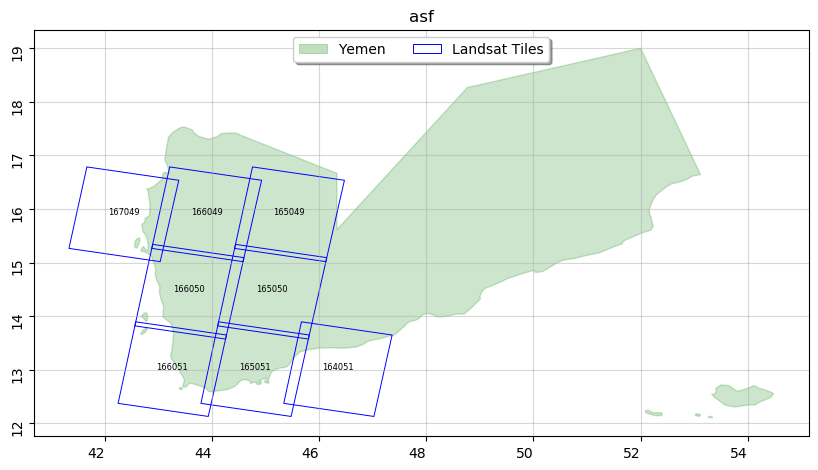

In [24]:
# Plot coverage
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

country.plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=country_name))

# country_s2_grans.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
# leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
# country_s2_grans.apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1)

# aois_s2_grans.plot(facecolor="none", edgecolor='b', lw=0.7, ax=ax)
# leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Landsat Tiles'))
# aois_s2_grans.apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1)

# country_ls_grans.plot(facecolor="none", edgecolor='b', lw=0.7, ax=ax)
# leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Landsat Tiles'))
# country_ls_grans.apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1)

aois_ls_grans.plot(facecolor="none", edgecolor='b', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='b', lw=0.7, label='Landsat Tiles'))
aois_ls_grans.apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1)

ax.set_title('asf')
ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

# Landsat Order

In [61]:
pr = aois_ls_grans
df = pd.read_csv('../Ancillary_Datasets/LANDSAT_8_C1_new.csv.gz') # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res3 = df


In [62]:
res3['AcquisitionDate'] = pd.to_datetime(res3['acquisitionDate'], format='%Y-%m-%d')
res3 = res3[(res3.AcquisitionDate>date(2019,9,8)) & (res3.AcquisitionDate<date(2020,1,1))] # SET TIME PERIOD
print('done')

done


/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [63]:
res3.LANDSAT_PRODUCT_ID.head()
print('done')

done


In [64]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)

In [1]:
# function for basic interaction with ESPA API - hacked together from their 'how to page'
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [6]:
# earth explorer credentials are required
host = 'https://espa.cr.usgs.gov/api/v1/'
#username = 'tom.jones'
#password = 'Welcome12'
username = 'sarah.cheesbrough'
password = 'SaCh_SatApps_USGS1'
# check login
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
200 OK
{
    "email": "Sarah.Cheesbrough@sa.catapult.org.uk",
    "first_name": "Sarah",
    "last_name": "Cheesbrough",
    "roles": [
        "active"
    ],
    "username": "sarah.cheesbrough"
}


In [9]:
## CHECK CONFLICTING ORDERS ###

# check for any existing orders that may prevent imediate processing of a fresh requestttttt
print('GET /api/v1/list-orders')
filters = {"status": ["complete", "ordered"]}  # Here, we ignore any purged orders
orders = espa_api('list-orders', body=filters)
print(json.dumps(orders, indent=4))

GET /api/v1/list-orders
200 OK
[
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061742-988",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061537-204",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061023-761",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-060110-664",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080959-437",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080506-662",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080423-123",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080244-635",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-053952-070"
]


In [33]:
with open ('../ls8_urls.txt', 'a') as f:
    for orderid in orders:
        resp = espa_api('item-status/{0}'.format(orderid), body={'status': 'complete'})
        for item in resp[orderid]:
            f.write(item.get('product_dload_url') + '\n')

200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK


In [68]:
### CHECK PRODUCT AVAILABILITY ###

# example of how to check available products for desired scenes
print('GET /api/v1/available-products')
avail_list = {'inputs': l8_list
             }
resp = espa_api('available-products', body=avail_list)
print(json.dumps(resp, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1TP_164049_20191003_20191003_01_RT",
            "LC08_L1TP_164050_20191003_20191003_01_RT",
            "LC08_L1TP_164051_20191003_20191003_01_RT",
            "LC08_L1TP_166049_20191001_20191001_01_RT",
            "LC08_L1TP_166050_20191001_20191001_01_RT",
            "LC08_L1TP_166051_20191001_20191001_01_RT",
            "LC08_L1TP_165049_20190924_20191001_01_RT",
            "LC08_L1TP_165050_20190924_20191001_01_RT",
            "LC08_L1TP_165051_20190924_20191001_01_RT",
            "LC08_L1TP_167049_20190922_20190926_01_T1",
            "LC08_L1TP_167050_20190922_20190926_01_T1",
            "LC08_L1TP_167051_20190922_20190926_01_T1",
            "LC08_L1TP_164049_20190917_20190926_01_T1",
            "LC08_L1TP_164050_20190917_20190926_01_T1",
            "LC08_L1TP_164051_20190917_20190926_01_T1",
            "LC08_L1TP_166049_20190915_20190925_01_T1",
            "LC

In [69]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)
print(len(l8_list))
er = []
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
ls = l8_list
#ls = [x (if x is not in er) for x in l8_list]
for i in er: 
    print(i)
    ls.remove(er)
print(len(ls))

18
18


In [71]:
### CREATE ORDER ###
# if any further subsetting is required. very recently acquired products are categorised as RT (as opposed to T1/T2). these are of insufficient certainty RE quality to be processed to ARD. this latency is unlikely to impact the non-NRT requirements of Common Sensing.
er = []
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
l8_ls = [e for e in l8_list if e not in (er)]
l8_ls = [i for i in l8_list if 'RT' not in i]

# specifying differing products across the sensors
l8_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
         
# determine available-products under their respective sensors
ls = l8_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order, indent=4))

# replace available products with what we wish to process
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):

        if set(l8_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l8_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'DY Veg'

# the order shoud now have changed from the original call available-products
print(json.dumps(order, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1TP_167049_20190922_20190926_01_T1",
            "LC08_L1TP_167050_20190922_20190926_01_T1",
            "LC08_L1TP_167051_20190922_20190926_01_T1",
            "LC08_L1TP_164049_20190917_20190926_01_T1",
            "LC08_L1TP_164050_20190917_20190926_01_T1",
            "LC08_L1TP_164051_20190917_20190926_01_T1",
            "LC08_L1TP_166049_20190915_20190925_01_T1",
            "LC08_L1TP_166050_20190915_20190925_01_T1",
            "LC08_L1TP_166051_20190915_20190925_01_T1"
        ],
        "products": [
            "source_metadata",
            "l1",
            "toa",
            "bt",
            "sr",
            "sr_ndvi",
            "sr_evi",
            "sr_savi",
            "sr_msavi",
            "sr_ndmi",
            "sr_nbr",
            "sr_nbr2",
            "stats",
            "pixel_qa"
        ]
    }
}
{
    "olitirs8_collection": {
        "inputs": 

In [15]:
orderid = orders[0]
print('GET /api/v1/order-status/{}'.format(orderid))
resp = espa_api('order-status/{}'.format(orderid))
print(json.dumps(resp, indent=4))

GET /api/v1/order-status/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821
200 OK
{
    "orderid": "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821",
    "status": "complete"
}


In [16]:
print('GET /api/v1/item-status/{0}'.format(orderid))
resp = espa_api('item-status/{0}'.format(orderid), body={'status': 'complete'})
print(json.dumps(resp[orderid], indent=4))

GET /api/v1/item-status/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821
200 OK
[
    {
        "cksum_download_url": "https://edclpdsftp.cr.usgs.gov/orders/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821/LC080750722015080501T1-SC20191025150256.md5",
        "completion_date": "2019-10-25 10:03:59.337312",
        "name": "LC08_L1TP_075072_20150805_20170406_01_T1",
        "note": "''",
        "product_dload_url": "https://edclpdsftp.cr.usgs.gov/orders/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821/LC080750722015080501T1-SC20191025150256.tar.gz",
        "status": "complete"
    },
    {
        "cksum_download_url": "https://edclpdsftp.cr.usgs.gov/orders/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821/LC080750712015080501T1-SC20191025150315.md5",
        "completion_date": "2019-10-25 10:04:19.669097",
        "name": "LC08_L1TP_075071_20150805_20170406_01_T1",
        "note": "''",
        "product_dload_url": "https://edclpdsf

In [ ]:
with open('your_file.txt', 'w') as f:
    for item in my_list:
        f.write("%s\n" % item)

In [24]:
urls = []
for orderid in orders:
    resp = espa_api('item-status/{0}'.format(orderid), body={'status': 'complete'})
    for item in resp[orderid]:
        urls.append(item.get('product_dload_url'))

200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK
200 OK


In [25]:
len(urls)

2535

In [21]:
!wget https://edclpdsftp.cr.usgs.gov/orders/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821/LC080750722015080501T1-SC20191025150256.tar.gz

--2019-10-30 13:01:02--  https://edclpdsftp.cr.usgs.gov/orders/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821/LC080750722015080501T1-SC20191025150256.tar.gz
Resolving edclpdsftp.cr.usgs.gov (edclpdsftp.cr.usgs.gov)... 152.61.133.101, 152.61.133.100, 2001:49c8:4000:121d::99
Connecting to edclpdsftp.cr.usgs.gov (edclpdsftp.cr.usgs.gov)|152.61.133.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392505240 (374M) [application/octet-stream]
Saving to: ‘LC080750722015080501T1-SC20191025150256.tar.gz’

LC08075072201508050 100%[===================>] 374.32M  8.74MB/s    in 39s     

2019-10-30 13:01:42 (9.52 MB/s) - ‘LC080750722015080501T1-SC20191025150256.tar.gz’ saved [392505240/392505240]



In [74]:
### CHECK STATUS OF ORDER ### 
orderid = resp['orderid']
print('GET /api/v1/order-status/{}'.format(orderid))
resp = espa_api('order-status/{}'.format(orderid))
print(json.dumps(resp, indent=4))

GET /api/v1/order-status/espa-Sarah.Cheesbrough@sa.catapult.org.uk-10102019-051603-151
200 OK
{
    "orderid": "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10102019-051603-151",
    "status": "ordered"
}


In [290]:
### EXTRACT URLS ###
urls = []
for item in resp[orderid]:
    urls.append(item.get('product_dload_url'))
print(urls)

KeyError: 'espa-Sarah.Cheesbrough@sa.catapult.org.uk-09262019-102739-043'